In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import scanpy.api as sc
from anndata import read_h5ad
from anndata import AnnData
import scipy as sp
import scipy.stats

import pickle

from itertools import product
from statsmodels.stats.multitest import multipletests


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
import sys
sys.path.append('../10_utils/')
import colorDict

age_color_dict = colorDict.age_color_dict()
tissue_color_dict = colorDict.tissue_color_dict()

## Load TISSUE DE result

In [3]:
tissue_dge_age_coef = pd.read_csv('./DGE_result.tissue.age_coef.csv', index_col=0)
tissue_dge_age_coef
tissue_dge_bh_p = pd.read_csv('./DGE_result.tissue.bh_p.csv', index_col=0)
tissue_dge_bh_p

,Aorta,BAT,Bladder,Brain_Myeloid,Brain_Non-Myeloid,Diaphragm,GAT,Heart,Heart_and_Aorta,Kidney,...,MAT,Mammary_Gland,Marrow,Pancreas,SCAT,Skin,Spleen,Thymus,Tongue,Trachea
Xkr4,1.998892e-01,1.884823e-02,3.136839e-02,4.581289e-01,1.137262e-08,2.369457e-01,3.670246e-01,4.907108e-01,0.594686,9.414663e-01,...,7.805674e-01,3.186044e-01,6.483304e-01,6.945946e-10,9.612419e-01,1.043041e-01,3.412960e-01,8.724292e-01,5.331863e-04,1.549619e-01
Rp1,4.322393e-01,1.107720e-02,3.054340e-01,2.573341e-01,6.981268e-02,7.344077e-03,1.288245e-01,3.044957e-01,0.688328,4.750900e-01,...,8.521761e-01,3.550678e-01,5.181973e-01,2.784846e-02,2.594512e-03,1.000000e+00,4.907672e-01,9.540959e-02,1.039365e-01,3.415681e-01
Sox17,3.560253e-03,2.456230e-05,1.334234e-10,9.318641e-05,7.713664e-11,1.055111e-03,6.768561e-02,8.556652e-03,0.011241,4.764265e-26,...,4.876062e-03,3.346403e-04,3.042564e-07,5.911308e-04,1.970416e-06,6.784083e-11,8.428076e-03,1.974592e-01,8.904845e-01,1.088782e-04
Mrpl15,5.255820e-04,8.483645e-01,4.079036e-08,1.561579e-08,6.245330e-43,3.770160e-01,2.471430e-14,1.944960e-06,0.000176,8.142430e-01,...,1.463118e-01,2.811932e-30,1.795249e-62,2.020635e-20,3.559972e-06,2.624126e-12,2.237991e-56,5.267314e-01,2.887437e-03,6.504242e-12
Lypla1,8.123588e-09,1.674648e-10,7.022051e-17,5.301601e-22,4.380148e-32,7.301670e-05,7.751988e-32,2.007847e-25,0.003124,1.151111e-39,...,1.790864e-04,4.517781e-03,3.676040e-146,6.127033e-49,4.199342e-16,3.792199e-82,2.175165e-84,7.617296e-13,4.404765e-96,6.795809e-48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOC434960,3.260573e-01,2.742950e-01,NaN,NaN,5.966071e-01,4.787152e-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.024953e-01,NaN,3.641977e-01,NaN,NaN,NaN,NaN
LOC380994,1.988980e-01,7.792968e-01,3.973386e-01,5.302505e-01,2.665411e-01,4.787152e-01,1.151202e-01,6.473643e-01,0.782384,4.034037e-01,...,4.353991e-01,NaN,4.202407e-02,NaN,NaN,6.676628e-01,9.152007e-01,NaN,3.612487e-01,2.867598e-01
LOC100041346,NaN,3.930798e-01,NaN,7.722631e-01,5.909119e-01,2.728917e-01,3.141559e-01,7.994278e-01,NaN,NaN,...,8.616722e-01,NaN,9.010345e-01,4.544541e-01,7.424337e-01,NaN,4.165995e-01,4.852439e-01,NaN,6.391656e-01
Sly,3.287724e-01,1.594087e-01,NaN,4.642468e-01,9.200499e-01,4.787152e-01,NaN,8.853336e-01,0.995351,NaN,...,NaN,NaN,1.269356e-01,4.544541e-01,NaN,NaN,4.164107e-01,1.367466e-01,4.016406e-01,NaN


In [4]:
sum(tissue_dge_age_coef.index.values == tissue_dge_bh_p.index.values)

20116

In [5]:
age_coef_threshold = 0.005
fdr_threshold = 0.01

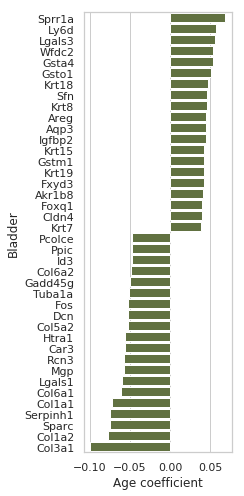

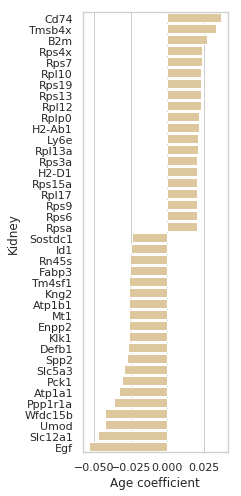

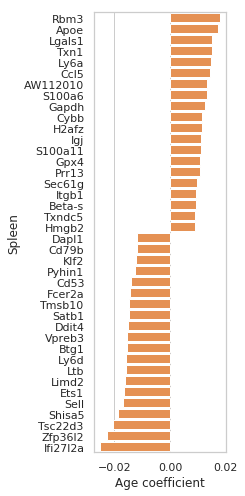

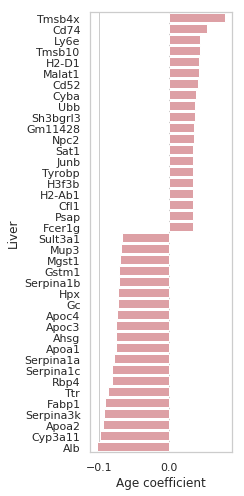

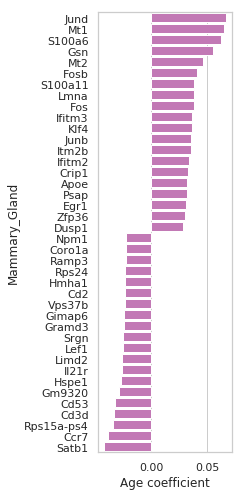

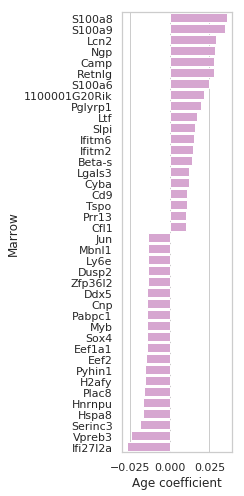

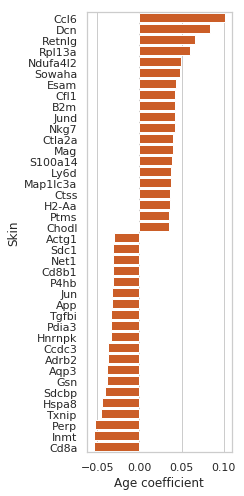

In [29]:
df_comparison = 0
    
for t in ['Bladder','Kidney','Spleen','Liver','Mammary_Gland','Marrow','Skin']:#tissue_dge_age_coef.columns:
    
    tiss_fdr = tissue_dge_bh_p[tissue_dge_bh_p[t]< fdr_threshold]
    tiss_age_coef = tissue_dge_age_coef.loc[tiss_fdr.index.values]
    tiss_age_coef = tiss_age_coef[np.absolute(tiss_age_coef[t])>age_coef_threshold][t]
    tiss_age_coef
    
    df = pd.DataFrame(tiss_age_coef.sort_values(ascending=False))
    df = df.reset_index()
    df.columns = ['gene','tissue']
    
    fig = plt.figure()
    fig.set_size_inches(3.5,7)
    g = sns.barplot(data=pd.concat([df.head(20),df.tail(20)],axis=0),
                y='gene',x='tissue',
                    color = tissue_color_dict[t])
    g.set(xlabel='Age coefficient', ylabel=t)
    plt.tight_layout()
    plt.savefig(t+'_dge.pdf')

## Load TISSUE-CELL TYPE DE result

In [ ]:
tissue_dge_age_coef = pd.read_csv('./DGE_result.tissue_cell.age_coef.csv', index_col=0)
tissue_dge_age_coef
tissue_dge_bh_p = pd.read_csv('./DGE_result.tissue_cell.bh_p.csv', index_col=0)
tissue_dge_bh_p

In [ ]:
sum(tissue_dge_age_coef.index.values == tissue_dge_bh_p.index.values)

In [ ]:
age_coef_threshold = 0.005
fdr_threshold = 0.01

In [ ]:
df_comparison = 0
    
for t in ['Bladder','Kidney','Spleen','Liver','Mammary_Gland','Marrow','Skin']:#tissue_dge_age_coef.columns:
    
    tiss_fdr = tissue_dge_bh_p[tissue_dge_bh_p[t]< fdr_threshold]
    tiss_age_coef = tissue_dge_age_coef.loc[tiss_fdr.index.values]
    tiss_age_coef = tiss_age_coef[np.absolute(tiss_age_coef[t])>age_coef_threshold][t]
    tiss_age_coef
    
    df = pd.DataFrame(tiss_age_coef.sort_values(ascending=False))
    df = df.reset_index()
    df.columns = ['gene','tissue']
    
    plt.figure()
    g = sns.barplot(data=pd.concat([df.head(10),df.tail(10)],axis=0),
                y='gene',x='tissue',
                    color = tissue_color_dict[t])
    g.set(xlabel='log(FC)', ylabel='Gene')
    plt.tight_layout()
    plt.savefig(t+'_dge.pdf')